In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist, pdist, squareform

plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (6, 4.5)

In [34]:
import warnings

warnings.filterwarnings("ignore")

In [35]:
import pygeostat as gs

# Helper functions

In [36]:
def get_valid_inputs(locs, values):
    if hasattr(values, "values"):
        values = values.values
    idxs = np.isfinite(values)
    if idxs.all():
        idxs = values >= 0.0
    values = values[idxs]
    locs = locs[idxs]
    return values, locs

# NN

In [37]:
def get_nn_weights(distance):
    weights = np.zeros_like(distance)
    weights[distance.argmin()] = 1.0
    return weights

In [38]:
def nn(data_locs, data_values, estimation_locs):
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    tree = KDTree(data_locs)
    dist, idxs = tree.query(grid_locs, k=1)
    weights = get_nn_weights(dist)
    est = np.sum(weights * data_values[idxs], axis=1)
    return est

# IDW

In [39]:
def get_idw_weights(dist, reg_const, power):
    weights = 1 / (reg_const + dist ** power)
    if dist.ndim == 2:
        return weights / weights.sum(axis=1).reshape(-1, 1)
    return weights / weights.sum()

In [40]:
def idw(
    data_locs, data_values, estimation_locs, power=2, reg_const=0.001, k_nearest=50,
):
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    tree = KDTree(data_locs)
    dist, idxs = tree.query(grid_locs, k=k_nearest)
    weights = get_idw_weights(dist, reg_const, power)
    est = np.sum(weights * data_values[idxs], axis=1)
    return est

# variograms

In [41]:
class SphericalCovariance:
    def __init__(self, ne, r, sill=1.0):
        self.r = r
        self.ne = ne
        self.sill = sill

    def apply_diag(self, cov):
        if cov.ndim == 2 and cov.shape[0] == cov.shape[1]:
            cov[np.eye(cov.shape[0], dtype=bool)] = self.sill
        return cov

    def __call__(self, d):
        d = d / self.r
        cov = np.zeros_like(d)
        idxs = d < 1.0
        cov[idxs] = (self.sill - self.ne) * (1.0 - d[idxs] * (1.5 - 0.5 * d[idxs] ** 2))
        return self.apply_diag(cov)


class ExponentialCovariance(SphericalCovariance):
    def __call__(self, d):
        d = d / self.r
        return self.apply_diag((self.sill - self.ne) * np.exp(-d))

# kriging

## simple

In [42]:
def get_simple_krige_weights(cov_func, data_locs, grid_data_dists):
    Ciu = cov_func(grid_data_dists)
    Cij = cov_func(squareform(pdist(data_locs)))
    return np.linalg.solve(Cij, Ciu)

## OK 

In [43]:
def get_ordinary_krige_weights(cov_func, data_locs, grid_data_dists):
    k_nearest = grid_data_dists.shape[0]
    Cij = np.ones((k_nearest + 1, k_nearest + 1))
    Cij[-1, -1] = 0.0
    Cij[:-1, :-1] = cov_func(squareform(pdist(data_locs)))
    Ciu = np.ones(k_nearest + 1)
    Ciu[:-1] = cov_func(grid_data_dists)
    return np.linalg.solve(Cij, Ciu)[:-1]

# RBF

In [44]:
def get_rbf_weights(kernel, data_locs, grid_data_dists, data_values):
    Kij = kernel(squareform(pdist(data_locs)))
    Kiu = kernel(grid_data_dists)
    weights = np.linalg.solve(Kij, Kiu)
    return weights

In [45]:
def rbf(data_locs, data_values, estimation_locs, kernel):
    data_values, data_locs = get_valid_inputs(data_locs, data_values)
    Kij = kernel(squareform(pdist(data_locs)))
    weights = np.linalg.solve(Kij, data_values)
    ests = np.full(grid_locs.shape[0], np.nan)
    for i, eloc in enumerate(estimation_locs):
        Kiu = kernel(cdist(np.atleast_2d(eloc), data_locs))[0]
        ests[i] = np.dot(weights, Kiu)
    ests[ests < 0.0] = 0.0
    return ests

In [46]:
class LinearKernel:
    def __call__(self, d):
        return d


class ThinPlateSpline:
    def __call__(self, d):
        cov = np.zeros_like(d)
        idxs = d > 0.0
        cov[idxs] = np.log(d[idxs]) * d[idxs] ** 2
        return cov

# import test data

## case 1

In [47]:
data = gs.DataFile("test.dat", x="x", y="y", z="z")
data.data = data.data.loc[data["var"] >= 0].reset_index(drop=True)
np.random.seed(2020)
# np.random.shuffle(data.data["var"])

In [48]:
vario = gs.Variogram(data, "var", omni3d=True, ndim=3, ndir=1)
vario.update_calcpars(diptol=90, nlags=25, lagdist=12, lagtol=8)
vario.varcalc()

         0, 0]
         match the calcpars and has been set to a [azm, dip, tilt]  value of:
         [0, 0, 0]


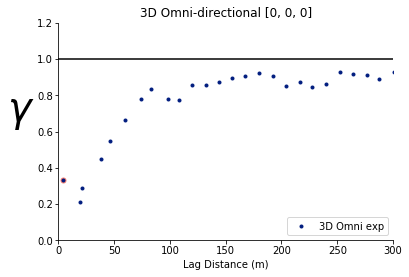

In [49]:
fig = vario.plot(varplt_kws=dict(minpairs=2), figsize=(6, 4))
gs.exportimg("vario.png")

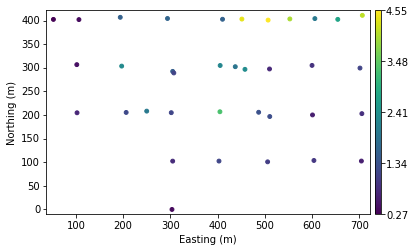

In [50]:
data.data = data.data.loc[(data["z"] >= -102) & (data["z"] <= -97) & (data["y"] < 425)]

data.data["z"] = 0.0

gs.locmap(data, var="var", figsize=(6, 6))
gs.exportimg("plan-locs.png")

In [51]:
tree = KDTree(data.get_locations())

### Query a location and display the weights

In [52]:
from copy import deepcopy
import matplotlib.colors as cm
from matplotlib.ticker import FixedLocator, ScalarFormatter

In [53]:
s = 35
lw = 0.5
cmap = cm.ListedColormap(plt.get_cmap("RdBu_r")(np.linspace(0.2, 0.8, 256)))
cmap2 = cm.ListedColormap(plt.get_cmap("RdBu_r")(np.linspace(0.5, 0.8, 256)))
norm = cm.DivergingNorm(vcenter=0.0)
vlim = (-0.1, None)

In [54]:
cov_func = SphericalCovariance(0.01, 150)
kernel = LinearKernel()

In [55]:
estimation_loc = [[475, 275, 0.0]]
data_locs = data.locations.values
data_grid_dists = cdist(estimation_loc, data_locs)[0]
data_values = data["var"]

In [56]:
results = deepcopy(data)

In [57]:
def label_0_on_cax(cax):
    ticks = [float(t.get_text()) for t in cax.yaxis.get_ticklabels()][::-1]
    pos = np.linspace(0, 1, len(ticks))
    ipos = np.interp(0.0, ticks, pos)
    ticks = [ticks[0], 0.0, ticks[-1]]
    cax.yaxis.set_ticks([0.0, ipos, 1.0])
    cax.yaxis.set_ticklabels(ticks)

### NN

In [58]:
name = "Nearest Neighbor Weight"

In [59]:
results[name] = get_nn_weights(data_grid_dists)

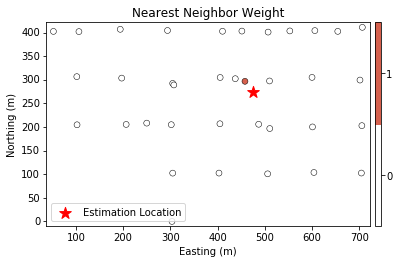

In [60]:
ax = gs.locmap(
    results,
    var=name,
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap={1: cmap.colors[-1], 0: "white"},
)
# label_0_on_cax(ax.cax)
ax.scatter(
    estimation_loc[0][0],
    estimation_loc[0][1],
    marker="*",
    s=150,
    c="red",
    label="Estimation Location",
)
ax.legend(loc="lower left")
gs.exportimg("plan-NN.png")

### SK

In [62]:
name = "Simple Kriging Weight"

In [63]:
results[name] = get_simple_krige_weights(cov_func, data_locs, data_grid_dists)

### OK

In [64]:
name = "Ordinary Kriging Weight"

In [65]:
results[name] = get_ordinary_krige_weights(cov_func, data_locs, data_grid_dists)

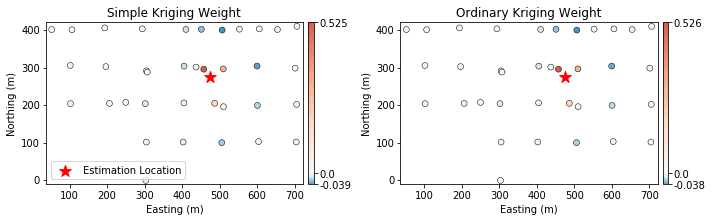

In [66]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
name = "Simple Kriging Weight"
ax = gs.locmap(
    results,
    var=name,
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
    ax=ax0
)
label_0_on_cax(ax0.cax)
ax0.scatter(estimation_loc[0][0], estimation_loc[0][1], marker="*", s=150, c="red", label='Estimation Location')
ax0.legend(loc='lower left')

name = "Ordinary Kriging Weight"
ax = gs.locmap(
    results,
    var=name,
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
    ax=ax1
)
label_0_on_cax(ax1.cax)
ax1.scatter(estimation_loc[0][0], estimation_loc[0][1], marker="*", s=150, c="red")
fig.tight_layout()
gs.exportimg("plan-kriging.png")

### ID2

In [67]:
name = "ID2 Weight"

In [68]:
results[name] = get_idw_weights(data_grid_dists, 0.01, 2)

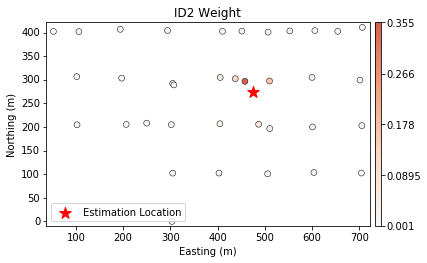

In [69]:
ax = gs.locmap(
    results,
    var=name,
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
)
ax.scatter(estimation_loc[0][0], estimation_loc[0][1], marker="*", s=150, c="red", label='Estimation Location')
ax.legend(loc='lower left')
gs.exportimg("plan-ID2.png")

### RBF

In [70]:
name = "RBF Weight"

In [71]:
results[name] = get_rbf_weights(kernel, data_locs, data_grid_dists, data_values)

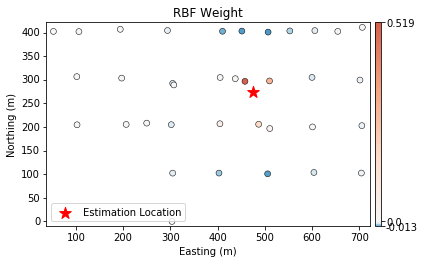

In [72]:
ax = gs.locmap(
    results,
    var=name,
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
)
label_0_on_cax(ax.cax)
ax.scatter(estimation_loc[0][0], estimation_loc[0][1], marker="*", s=150, c="red", label='Estimation Location')
ax.legend(loc='lower left')
gs.exportimg("plan-RBF.png")

## case 2

In [73]:
data = gs.DataFile("test.dat", x="x", y="y", z="z")
data.data = data.data.loc[data["var"] >= 0].reset_index(drop=True)

In [74]:
data.data = data.data.loc[(data["x"] >= 400) & (data["x"] <= 410)]
data.data['x'] = 0.0

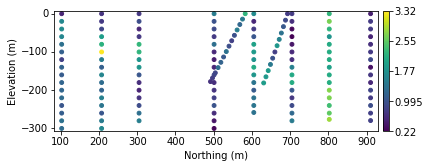

In [75]:
gs.locmap(data, var='var', orient='yz', figsize=(6, 6))
gs.exportimg("yz-locs.png")

In [76]:
tree = KDTree(data.get_locations())

### Query a location and display the weights

In [77]:
from copy import deepcopy
import matplotlib.colors as cm
from matplotlib.ticker import FixedLocator, ScalarFormatter

In [78]:
s = 35
lw = 0.5
cmap = cm.ListedColormap(plt.get_cmap("RdBu_r")(np.linspace(0.2, 0.8, 256)))
cmap2 = cm.ListedColormap(plt.get_cmap("RdBu_r")(np.linspace(0.5, 0.8, 256)))
norm = cm.DivergingNorm(vcenter=0.0)
vlim = (-0.1, None)

In [79]:
cov_func = SphericalCovariance(0.01, 150)
kernel = LinearKernel()

In [80]:
estimation_loc = [[0.0, 550, -175]]
data_locs = data.locations.values
data_grid_dists = cdist(estimation_loc, data_locs)[0]
data_values = data["var"]

In [81]:
results = deepcopy(data)

In [82]:
def label_0_on_cax(cax):
    ticks = [float(t.get_text()) for t in cax.yaxis.get_ticklabels()][::-1]
    pos = np.linspace(0, 1, len(ticks))
    ipos = np.interp(0.0, ticks, pos)
    ticks = [ticks[0], 0.0, ticks[-1]]
    cax.yaxis.set_ticks([0.0, ipos, 1.0])
    cax.yaxis.set_ticklabels(ticks)

### NN

In [83]:
name = "Nearest Neighbor Weight"

In [84]:
results[name] = get_nn_weights(data_grid_dists)

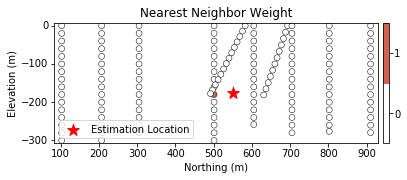

In [85]:
ax = gs.locmap(
    results,
    var=name,
    orient="yz",
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap={1: cmap.colors[-1], 0: "white"},
)
# label_0_on_cax(ax.cax)
ax.scatter(
    estimation_loc[0][1],
    estimation_loc[0][2],
    marker="*",
    s=150,
    c="red",
    label="Estimation Location",
)
ax.legend(loc="lower left")
gs.exportimg("yz-NN.png")

### SK

In [87]:
name = "Simple Kriging Weight"

In [88]:
results[name] = get_simple_krige_weights(cov_func, data_locs, data_grid_dists)

### OK

In [89]:
name = "Ordinary Kriging Weight"

In [90]:
results[name] = get_ordinary_krige_weights(cov_func, data_locs, data_grid_dists)

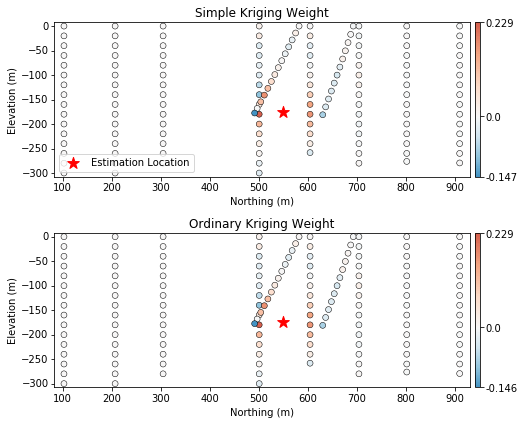

In [91]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 6))
name = "Simple Kriging Weight"
ax = gs.locmap(
    results,
    var=name,
    orient='yz',
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
    ax=ax0
)
label_0_on_cax(ax0.cax)
ax0.scatter(
    estimation_loc[0][1],
    estimation_loc[0][2],
    marker="*",
    s=150,
    c="red",
    label="Estimation Location",
)
ax0.legend(loc="lower left")

name = "Ordinary Kriging Weight"
ax = gs.locmap(
    results,
    var=name,
    orient='yz',
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
    ax=ax1
)
label_0_on_cax(ax1.cax)
ax1.scatter(estimation_loc[0][1], estimation_loc[0][2], marker="*", s=150, c="red")
fig.tight_layout()
gs.exportimg("yz-kriging.png")

### ID2

In [92]:
name = "ID2 Weight"

In [93]:
results[name] = get_idw_weights(data_grid_dists, 0.01, 2)

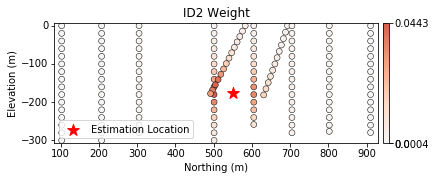

In [94]:
ax = gs.locmap(
    results,
    var=name,
    orient='yz',
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
)
label_0_on_cax(ax.cax)
ax.scatter(
    estimation_loc[0][1],
    estimation_loc[0][2],
    marker="*",
    s=150,
    c="red",
    label="Estimation Location",
)
ax.legend(loc="lower left")
gs.exportimg("yz-ID2.png")

### RBF

In [95]:
name = "RBF Weight"

In [96]:
results[name] = get_rbf_weights(kernel, data_locs, data_grid_dists, data_values)

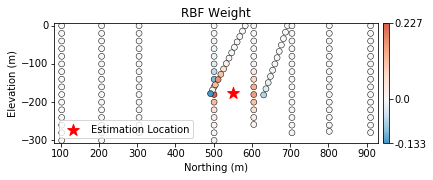

In [97]:
ax = gs.locmap(
    results,
    var=name,
    orient='yz',
    figsize=(6, 6),
    title=name,
    s=s,
    edgecolors="k",
    lw=lw,
    cmap=cmap,
    norm=norm,
)
label_0_on_cax(ax.cax)
ax.scatter(
    estimation_loc[0][1],
    estimation_loc[0][2],
    marker="*",
    s=150,
    c="red",
    label="Estimation Location",
)
ax.legend(loc="lower left")
gs.exportimg("yz-RBF.png")